# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky importujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [333]:
import requests
import re
import time
import pandas as pd
from bs4 import BeautifulSoup

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import warnings
from ipywidgets import interact
import networkx as nx

# Website analysis

While browsing through the individual votings, I noticed that the URL of each of them contains a specific index (Voting ID) which identifies the voting. Going from one voting to the next is done by simply incrementing this index, therefore I noted down the index of the first and the last voting in order to make browsing the domain more efficient.

In [334]:
# important information extracted from website analysis

voting_start = 67018 # index hidden in the URL of the first voting
voting_end = 73901 # index in the URL of the last voting
char_set = 'windows-1250' # document character set for the website

# constants

VOTINGS_FILE = 'data/votings.csv' # file to store general data about each voting that took place
INDIVIDUALS_FILE = 'data/individuals.csv' # file to store data about every single cast vote 
PARTIES_FILE = 'data/parties.csv' # file to store data about every paty's collective result for each voting
PARTY_MEMBERS_SIMILARITY_FILE = 'data/similarity.txt' # file to store similarity calculations for visual no. 5

COLLECT_DATA = False # setting to True will delete saved data
PROCESS_SIMILARITIES = False # setting to True will delete saved data

# Web scraping

The following section performs web scraping on the given domain. It will only run if the constant COLLECT_DATA is set to True. I have decided to split the data into three different data frames:
* **votings (data/votings.csv)** - this df contains information about each individual voting that took place in the chamber of deputies (Voting ID, Meeting number, Voting number, Subject/Name, Number of voters, Number of Yes votes, Number of No votes, Number of Unregistered votes, Number of Refrained votes, Number of Excused votes, Whether the agenda was accepted, Whether the voting was pronounced as Valid)
<br/><br/>
* **individuals (data/individuals.csv)** - this df contains information about every single vote cast by each deputy (Deputy name, Deputy's party, Voting ID, Vote cast)
<br/><br/>
* **parties (data/parties.csv)** - this df contains information about each party's collective result in every single voting (Party's name, Voting ID, Number of Yes votes, Number of No votes, Number of Unregistered votes, Number of Refrained votes, Number of Excused votes, Which of the votes was most common - Yes/No/Other)
<br/><br/>
I believe this specific data organization will be useful when visualizing data, because not only will I have information about the results of each voting, but I will also be able to acces data about the result structure (how each deputy voted, how each party viewed the voting as a collective, etc.). The information about parties' votes could be calculated from the individuals data frame, but I think it would be less efficient so I decided to store the data in a separate file.

In [335]:
# creates csv files to store data in (if files already exist, they get wiped)
def setup_files():
    f = open(VOTINGS_FILE, 'w', encoding='utf-8')
    f.write('Voting ID;Meeting number;Voting number;Subject;Number of voters;Yes;No;Unregistered;Refrained;Excused;Passed;Valid\n')
    f.close()
    
    f2 = open(INDIVIDUALS_FILE, 'w', encoding='utf-8')
    f2.write('Name;Party;Voting ID;Vote\n')
    f2.close()
    
    f3 = open(PARTIES_FILE, 'w', encoding='utf-8')
    f3.write('Party;Voting ID;Yes;No;Unregistered;Refrained;Excused;Max\n')
    f3.close()


# function takes header of the website and returns a list including its basic information
# [meeting number, voting number, date, time, subject]
def split_header(header):
    match = re.search(r'[0-9][0-9]:[0-9][0-9]', header)
    if not match:
        raise Exception('Unable to split header')
    split = match.end()
    arr = [header[:split], header[split:]]
    res = [x.strip() for x in arr[0].split(',')]
    res.append(arr[1].strip() if len(arr[1]) > 0 else "''")
    res[0] = res[0].split('.')[0]
    res[1] = res[1].split('.')[0]
    return res
    

# extracts general information about a single voting and appends it to the votings.csv file
def process_voting(voting_index, soup):
    main = soup.find('div', { 'id' : 'main-content' })

    # process header
    voting_header = soup.find('h1', { 'class' : 'page-title-x' }).get_text()
    header = split_header(voting_header)
    f = open(VOTINGS_FILE, 'a', encoding='utf-8')
    f.write(f'{voting_index};{header[0]};{header[1]};{header[4]}; ')

    # process vote summary table
    cell = soup.find_all('i', text=re.compile('Celkem'))[0].parent.parent
    curr = cell.next_sibling
    for i in range(6):
        f.write(f'{curr.get_text()};')
        curr = curr.next_sibling

    # vote passed?
    summary = soup.find('div', {'class' : 'summary'})
    result = summary.find('span')
    f.write('1;') if result.get_text() == 'NÁVRH BYL PŘIJAT' else f.write('0;')

    # valid election?
    status = soup.find_all('p', {'class': 'status invalid'})
    f.write('{valid}'.format(valid='0' if len(status) > 0 and status[0] == "Hlasování bylo prohlášeno za zmatečné." else '1\n'))
    f.close()
        

# extracts the data about a party's collective result in a given voting and appends this information to the parties.csv file
def process_party(voting_index, soup, party_info, text, name):
    f = open(PARTIES_FILE, 'a', encoding='utf-8')
    nums = party_info.find('span', {'class' : 'results'}).find_all('strong')
    
    i = 0
    if 'Ano:' in text:
        yes = nums[i].get_text()
        i += 1
    else:
        yes = 0
            
    if 'Ne:' in text:
        no = nums[i].get_text()
        i += 1
    else:
        no = 0
        
    if 'Nepřihlášen:' in text:
        unregistered = nums[i].get_text()
        i += 1
    else:
        unregistered = 0
        
    if 'Zdržel se:' in text:
        refrained = nums[i].get_text()
        i += 1
    else:
        refrained = 0
        
    if 'Omluven:' in text:
        excused = nums[i].get_text()
        i += 1
    else:
        excused = 0
    
    sums = {'Y': int(yes), 'N': int(no), 'O': int(unregistered) + int(refrained) + int(excused)}
    
    #print(f'{name}: {yes},{no},{unregistered},{refrained},{excused},{max(sums, key=lambda key: sums[key])}')
    f.write(f'{name};{voting_index};{yes};{no};{unregistered};{refrained};{excused};{max(sums, key=lambda key: sums[key])}\n')
    f.close()
        

# extracts some data about each party's vote in a given voting and sends this data over to the process_parties()
# function where they are further processed and stored
# for each party, the function analyses individual deputies' votes and stores them in the individuals.csv file
# vote: A (yes), N (no), 0 (Unregistered), Z (refrained), M (excused)
def process_individuals(voting_index, soup):
    party_tables = soup.find('div', {'id' : 'main-content'}).find_all('h2', {'class' : 'section-title center'})[1:]
    res_tables = soup.find_all('ul', {'class' : 'results'})
    
    for i in range(len(party_tables) - 1):
        party_info = party_tables[i].find('span')
        text = party_info.get_text()
        if 'Tabulkovy vypis' in text:
            continue

        tmp = text.split(" ", 1)
        party_name = text.split(' ', 1)[0]
        process_party(voting_index, soup, party_info, text, party_name)
        
        party_voters = res_tables[i].find_all('li')
        f2 = open(INDIVIDUALS_FILE, 'a', encoding='utf-8')
        for voter in party_voters:
            name = voter.find('a').get_text()
            vote = voter.find('span').contents[0]
            #print(f'{name}, {party_name}, {vote}')
            f2.write(f'{name};{party_name};{voting_index};{vote}\n')
        f2.close()


# sends GET request to URL given by a specific voting ID, creates a soup object and sends data for further processing
# if voting results have not yet been published and finalized, an error message informs the user about its Voting ID
def process_page(voting_index):
    try:
        url = f'https://www.psp.cz/sqw/hlasy.sqw?g={voting_index}&l=cz'
        res = requests.get(url)
        html_page = res.content
        soup = BeautifulSoup(html_page, 'html.parser', from_encoding=char_set)
        
        process_voting(voting_index, soup)
        process_individuals(voting_index, soup)
    except Exception as e:
        print(f'Could not parse page: {voting_index} ... {e}')


# main function leading the whole web scraping process
# ensures a 1 second wait time between each request so as not to overload the targeted domain
def process_data():
    start = time.time()
    setup_files()
    
    for i in range(voting_start, voting_end + 1):
        if i % 100 == 0:
            print(f'Processing page: {i}')
        process_page(i)
        time.sleep(1)
        
    end = time.time()
    print(end - start)


if COLLECT_DATA:
    print('Starting data collection...')
    process_data()

# Load data

In [336]:
# load data
df_v = pd.read_csv('data/votings.csv', delimiter=';', skipinitialspace=True, skip_blank_lines=True, encoding='utf-8')
df_i = pd.read_csv('data/individuals.csv', delimiter=';', skipinitialspace=True, skip_blank_lines=True, encoding='utf-8')
df_p = pd.read_csv('data/parties.csv', delimiter=';', skipinitialspace=True, skip_blank_lines=True, encoding='utf-8')

# 1. Comparison of the most common vote between political parties
* The purpose of this visual is to take into account all votings and see how similarly the political parties voted
* Two parties' collective votes match if that type of vote was cast by the most members in each of the party
* Three types of votes were distinguished: Yes, No, Other (Refrained + Unregistered + Excused)
* Task completed by this visual:
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně

### Data processing
* Create a vector for each party and fill it with the most common vote for each voting that took place
* Compare two parties' vectors and save their similarity (on how many votings did the match in %)

In [337]:
df1 = df_p[df_p.Party != "Nezařaz"]
parties = (df1[df1['Voting ID'] == voting_start])['Party']
party_cnt = len(parties)

# create party vectors
party_matrix = []
for p in range(party_cnt):
    vec = df1[df1.Party == parties[p]]
    vec = vec['Max'].tolist()
    party_matrix.append([])
    for v in range(len(vec)):
        party_matrix[p].append(vec[v])         

voting_cnt = len(party_matrix[0])

# create matrix showing the similarity of parties' votes
similarity_matrix = np.zeros(shape=(len(parties), len(parties)))
for first in range(party_cnt):
    for second in range(party_cnt):
        matched = 0
        for voting in range(voting_cnt):
            if party_matrix[first][voting] == party_matrix[second][voting]:
                matched += 1
        similarity_matrix[first][second] = matched / voting_cnt
        #print(f'{first} and {second} matched {matched}x')

### Visualization
* I chose to represent the similarity of parties' votes with a heatmap
* I have a matrix where each cell is indexed by a combination of two parties and its value is the percentage of similarity between the two parties' votes
* Cells are colored based on their values, this legend can be seen alongside the heatmap in the color bar

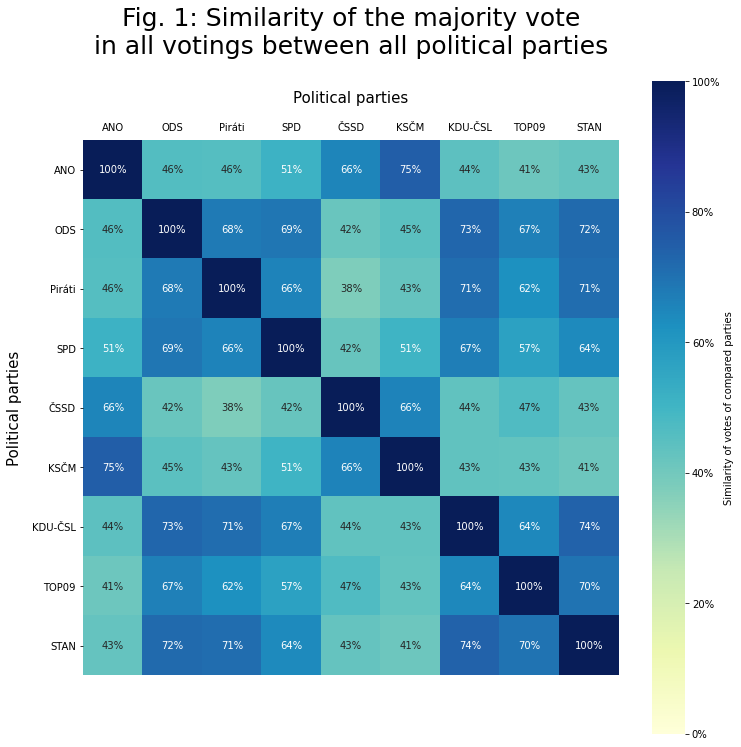

In [338]:
# visualize results using a heatmap
fig, ax = plt.subplots(figsize=(12, 12))

fmt = lambda x,pos: '{:.0%}'.format(x)
sns.heatmap(similarity_matrix, vmin=0, vmax=1, annot=True, square=True, cmap='YlGnBu', fmt='.0%',
            cbar_kws={'format': FuncFormatter(fmt), 'label' : 'Similarity of votes of compared parties'})
ax.set_xticklabels(parties.tolist())
ax.set_yticklabels(parties.tolist(), rotation=0)
ax.set_title('Fig. 1: Similarity of the majority vote\nin all votings between all political parties', fontsize=25, y=1.15)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xlabel('Political parties', fontsize=15, labelpad=20)
plt.ylabel('Political parties', fontsize=15, labelpad=10)
ax.xaxis.set_label_position('top')

### Interpretation
* Obviously we can see that each party matches its own votes on 100 % of the votings, this is a good sanity check
* Based on the results, we can also establish that the parties KSČM and ANO tend to vote similarly and the same can be said for ODS and KDU-ČSL and STAN
* On the other hand, Piráti and ČSSD have the lowest similarity

# 2. Attendence of parties over time
* The purpose of this visual is to show how the overall attendence of each party at the votings has evolved through time
* Tasks completed by this visual:
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek
    * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.)

### Data processing
* For each party, I count the number of votes that were either 'Yes', 'No' or 'Refrained' which tells me that the deputies that cast these votes were definitely present and I divide it by the total number of votes for that party
* This gives me attendence of the given party as a percentage and I calculate this value for each voting that took place in order to see how the values evolved

In [339]:
warnings.filterwarnings('ignore')
print('Processing data...')
start = time.time()

df1 = df_p[df_p.Party != "Nezařaz"]
parties = (df1[df1['Voting ID'] == voting_start])['Party']
party_cnt = len(parties)

attendence_arr = []
for p in range(party_cnt):
    curr = df1[df1.Party == parties[p]]
    
    for df_index, row in curr.iterrows():
        attended = row.Yes + row.No + row.Refrained
        total = attended + row.Unregistered + row.Excused
        curr.loc[df_index, 'Attendence'] = attended / total
    attendence_arr.append(curr)
    
print('Done...')
end = time.time()
print(f'\nTime: {end - start}')

Processing data...
Done...

Time: 20.788377046585083


### Visualization
* I have chosen to plot the data as a line chart over time, where the x axis is the voting id (which represents the sequential order of votings over time) and the y axis is specific for each party and gives the percentage range of the party's attendence
* Each sub chart is labeled by the party's name and color

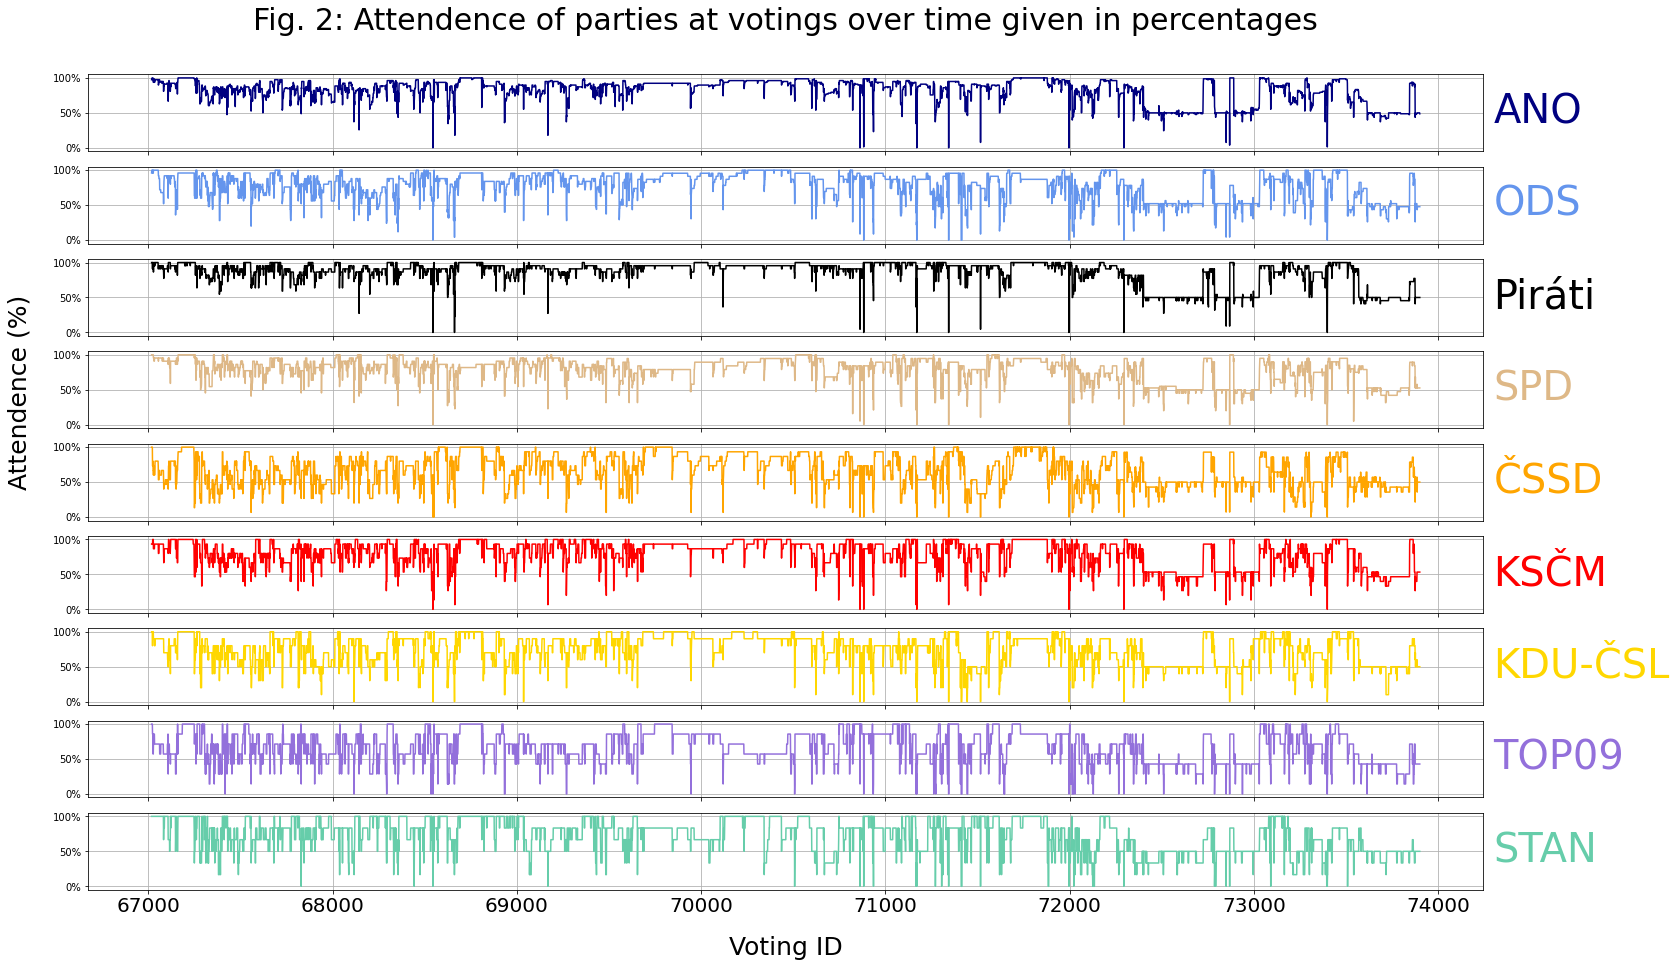

In [340]:
fig, axes = plt.subplots(9,1, figsize=(25,15), sharex=True)
colors = ['navy', 'cornflowerblue', 'black', 'burlywood', 'orange', 'red', 'gold', 'mediumpurple', 'mediumaquamarine']
plt.xlabel('Voting ID', fontsize=25, labelpad=20)
fig.text(0.08, 0.5, 'Attendence (%)', fontsize=25, rotation=90)

axes[0].set_title('Fig. 2: Attendence of parties at votings over time given in percentages', fontsize=30, y=1.5)
plt.xticks(fontsize=20)

for i in range(len(attendence_arr)):
    curr = attendence_arr[i]
    axes[i].plot(curr['Voting ID'], curr['Attendence'], linewidth=1.5, color=colors[i])
    axes[i].get_yaxis().set_major_formatter(FuncFormatter(fmt))
    axes[i].grid(True)
    axes[i].text(74300, 0.35, curr['Party'].tolist()[0], fontsize=40, color=colors[i])
    
plt.show()

### Interpretation
* We can see that the parties' attendence is definitely not stable, but they generally tend to be present at similar levels, no party is a clear outlier here
* An interesting thing to note is that around the voting id 70 000, there has been a stable high attendence - I have found that this voting id corresponds to roughly the time around spring/summer of 2019, however, I cannot think of a specific event that would have caused the high attendence
* One explainable trend seen in the chart is that around the voting 72 500, we notice a sudden drop in attendence and it stays level around the 50 % mark for a long time, then it rises and then goes back down - the time frame is the coronavirus pandemic that's currently taking place, the first drop happened around April 2020 when the virus first started spreading in the Czech Republic, then the summer was calmer and deputies attended the votings in higher numbers and then again since the end of summer, the attendence has been dropping
* Such extraordinary events would have to be taken into account if we were to build predictive models trained on this dataset, because the current pandemic is not representative of the general situation and therefore our model would be biased and inaccurate in predicting out of sample (if the sample is the year 2020 for example)

# 3. Individual attendence of the deputies
* The purpose of this visual is to be able to analyze each individual member's attendence per their party
* Task completed by this visual:
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek

### Data processing
* The data processing for individuals works very similarly to that of the whole party, each individual's total of attended votings is summed and divided by the total votings

In [341]:
print('Processing data...')
start = time.time()

party_list = (df1[df1['Voting ID'] == voting_end])['Party'].tolist()

all_absences = {}

for p in party_list:
    curr = df_i[df_i['Party'] == p]
    absences = {}
    
    for df_index, row in curr.iterrows():
        if row['Name'] in absences:
            if row['Vote'] == 'A' or row['Vote'] == 'N' or row['Vote'] == 'Z':
                absences[row['Name']]['Present'] += 1
            else:
                absences[row['Name']]['Absent'] += 1
        else:
            absences[row['Name']] = {}
            if row['Vote'] == 'A' or row['Vote'] == 'N' or row['Vote'] == 'Z':
                absences[row['Name']]['Present'] = 1
                absences[row['Name']]['Absent'] = 0
            else:
                absences[row['Name']]['Present'] = 0
                absences[row['Name']]['Absent'] = 1
    all_absences[p] = absences

print('Done')
end = time.time()
print(f'\nTime: {end - start}')

Processing data...
Done

Time: 102.1195421218872


### Visualization
* I have decided to show the results with an interactive horizontal bar graph
* Upon selecting a specific party, its results are shown
* On the y axis we can see the list of the party's members and their attendence given by percentage is drawn on the x axis

In [342]:
@interact
def show(Party=party_list):
    it = list(all_absences[Party].items())
    it.sort(key=lambda x: x[1]['Present']/(x[1]['Present']+ x[1]['Absent']), reverse=True)

    f, ax = plt.subplots(figsize=(10, len(it) * 0.2))
    
    x, y = zip(*it)
    y_list = []
    for i in y:
        y_list.append(i['Present'] / (i['Present'] + i['Absent']))
    ax = sns.barplot(y_list, list(x), label="Total", color=colors[party_list.index(Party)])
    ax.get_xaxis().set_major_formatter(FuncFormatter(fmt))
    plt.xlabel('Attendence (%)', fontsize=15, labelpad=20)
    plt.ylabel('Name of deputy', fontsize=15, labelpad=20)
    ax.set_title('Fig. 3: Attendence of members of each political party', fontsize=20, y=1.03)
    plt.show()

interactive(children=(Dropdown(description='Party', options=('ANO', 'ODS', 'Piráti', 'SPD', 'ČSSD', 'KSČM', 'K…

### Interpretation
* The results are quite self explanatory, but we can immediately notice that deputies with the lowest attendences seem to be Andrej Babiš for ANO and Karel Schwarzenberg for TOP09

# 4. Visualization of deputies' movements between parties
* The purpose of this visual is to see how much deputies enter, leave or switch political parties
* Task completed by this visual:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami

### Data processing
* For each pair of successive votings, I compare the sets of names of the deputies that took part in those votings and based on the difference of these two sets, I can recognize which members have entered political parties and which have left
* I save these changes as directed edges between nodes, where nodes are political parties
* If a deputy left one party and didn't appear in another, then an edge between the party and the node 'Leaving' is added
* Similarly if a deputy entered a party and wasn't a member of a different one before, an edge from the node 'Entering' to the new party is saved
* Output of this preprocessing is shown bellow the cell, where each change in the parties' members is described

In [343]:
start = time.time()

all_parties = party_list + ['Nezařaz']

def compare_votings(first_id, second_id):
    first = df_i.loc[df_i['Voting ID'] == first_id]
    second = df_i.loc[df_i['Voting ID'] == second_id]
    diffs= []
    for p in all_parties:
        first_names = set(first.loc[first['Party'] == p]['Name'])
        second_names = set(second.loc[second['Party'] == p]['Name'])
        #print(first_names.difference(second_names)) #leaving
        #print(second_names.difference(first_names)) #coming
        diffs.append((first_names.difference(second_names), second_names.difference(first_names)))
        
    return diffs

print("### List of changes in the parties' members ###")
edges = []
edge_labels = {}
for index in range(len(df_v) - 1):
    diffs = compare_votings(df_v.iloc[index]['Voting ID'], df_v.iloc[index + 1]['Voting ID'])
    vote_id = df_v.iloc[index]['Voting ID']

    for i in range(len(all_parties)):
        curr = diffs[i] # party's leaving and entering members

        if len(curr[0]) == 0: # no leaving members
            continue
        else:
            for leaving in curr[0]:
                print("----------")
                print(f'Voting ID: {vote_id}')
                print(leaving, end=" ")
                found = False
                for j in range(len(all_parties)):
                    if leaving in diffs[j][1]:
                        print(f'left {all_parties[i]} and entered {all_parties[j]}')
                        found = True
                        edges.append([all_parties[i], all_parties[j]])
                        pair = (all_parties[i], all_parties[j])
                        if pair in edge_labels:
                            edge_labels[pair] += 1
                        else:
                            edge_labels[pair] = 1
                        

                if not found:
                    print(f'left {all_parties[i]}')
                    edges.append([all_parties[i], 'Leaving'])
                    pair = (all_parties[i], 'Leaving')
                    if pair in edge_labels:
                        edge_labels[pair] += 1
                    else:
                        edge_labels[pair] = 1
            
        
        # handle entering of members with no previous party membership
        if len(curr[1]) == 0: # no entering members
            continue
        else:
            for entering in curr[1]:
                print("----------")
                print(f'Voting ID: {vote_id}')
                print(entering, end=" ")
                found2 = False
                for j in range(len(all_parties)):
                    if entering in diffs[j][0]:
                        found2 = True
                        break

                if not found2:
                    print(f'entered the chamber of deputies as a member of {all_parties[i]}')
                    edges.append(['Entering', all_parties[i]])
                    pair = ('Entering', all_parties[i])
                    if pair in edge_labels:
                        edge_labels[pair] += 1
                    else:
                        edge_labels[pair] = 1

end = time.time()
print(f'\nTime: {end - start}')

### List of changes in the parties' members ###
----------
Voting ID: 67033
Jaroslava Pokorná Jermanová left ANO
----------
Voting ID: 67033
Jiří Hlavatý left ANO
----------
Voting ID: 67033
Milan Pour entered the chamber of deputies as a member of ANO
----------
Voting ID: 67033
Eva Matyášová entered the chamber of deputies as a member of ANO
----------
Voting ID: 67033
Martin Půta left STAN
----------
Voting ID: 67033
Petr Pávek entered the chamber of deputies as a member of STAN
----------
Voting ID: 67516
Bohuslav Sobotka left ČSSD
----------
Voting ID: 67516
Roman Sklenák entered the chamber of deputies as a member of ČSSD
----------
Voting ID: 67895
Robert Pelikán left ANO
----------
Voting ID: 67895
Monika Červíčková entered the chamber of deputies as a member of ANO
----------
Voting ID: 68228
Martin Stropnický left ANO
----------
Voting ID: 68228
Petr Venhoda entered the chamber of deputies as a member of ANO
----------
Voting ID: 68568
Vladimír Koníček left KSČM
----------
Vo

### Visualization
* I have chosen to visualize this problem as a classical graph with nodes representing parties (and the state of leaving or entering a party) and edges representing the movement between parties
* Each edge is labeled by a number which is the number of movements in the given direction over the analyzed period of time and is directed in the logical sense of where the member is transfering

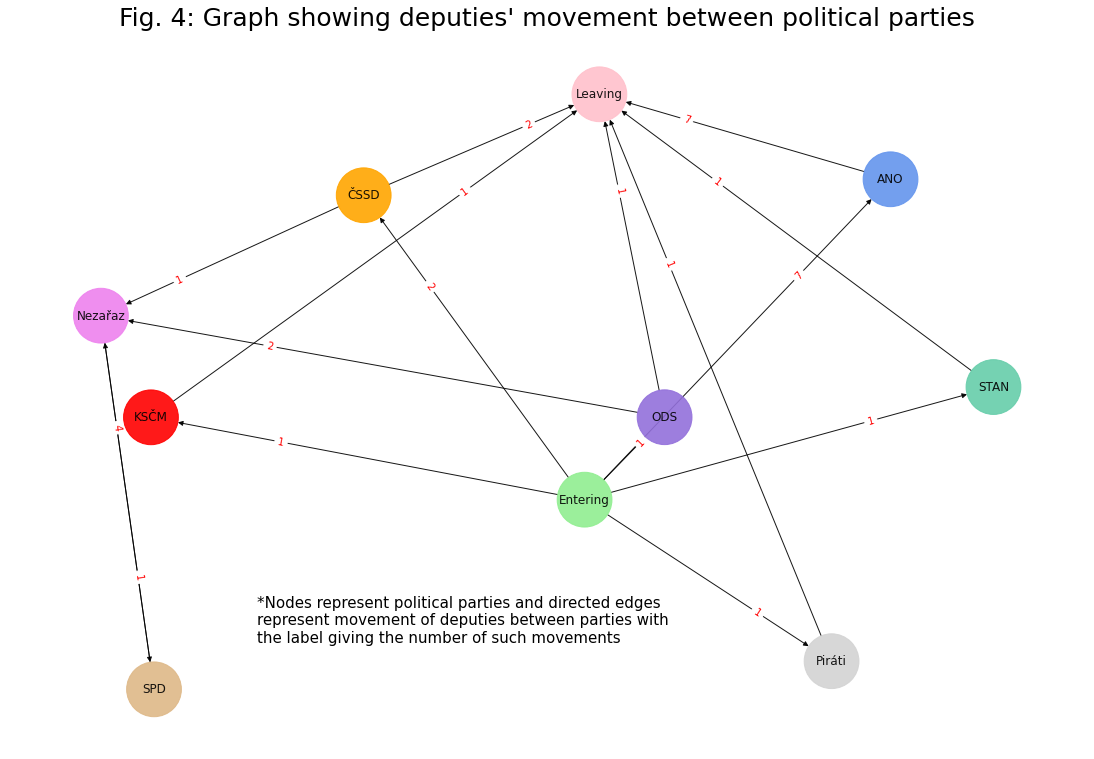

In [344]:
color_map = ['cornflowerblue', 'pink', 'lightgreen', 'mediumaquamarine', 'orange', 'red', 'mediumpurple', 'violet', 'burlywood', 'lightgray']

G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=70, k=1.8)
plt.figure(figsize=(15,10))
nx.draw(G,pos, node_color=color_map, edge_color='black',width=1,linewidths=1,\
node_size=3000, alpha=0.9,\
labels={node:node for node in G.nodes()})
nx.draw_networkx_edge_labels(G,pos, edge_labels=edge_labels, font_color='red', label_pos=0.3)
plt.axis('off')
plt.title("Fig. 4: Graph showing deputies' movement between political parties", fontsize=25, y=1)
plt.text(-0.6, -0.7, '*Nodes represent political parties and directed edges\nrepresent movement of deputies between parties with\nthe label giving the number of such movements', fontsize=15)
plt.show()

### Interpretation
* Overall we can see that the chamber of deputies is quite stable, there have not been many changes over the analyzed time period
* We can see that the biggest change was in the party ANO, where 7 new members entered the chamber to represent this party
* Two members of ČSSD have completely left the chamber, whereas other parties lost only one deputy at most
* The biggest transfer can be seen from SPD to Nezařaz (which is not really a party, but rather a common group for deputies with no party affiliation, so the 4 SPD members became independent)

# 5. Distribution of the average similarity of each deputy's votes to the collective vote of their party

* The purpose of this visual is to give an idea about how the individual deputies vote in relation to their whole party
* Tasks completed by this visual:
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové)

### Data processing
* The data processing for this visual had a very high time complexity, therefore I chose to save its results into a separate file 'data/similarity.txt' and load the saved list of values directly for the visualization
* For each party, I analyze all its members and return a list of their respective similarities to the party's vote
* The similarity is computed as the number of times the deputy voted the same as the party in a single voting divided by the total number of times the deputy voted for the party
* Votings where the majority of the party did not vote or refrained are excluded from the statistic

In [345]:
res = []

def process_member_vote(row, party_list, p, all_votes):
    member_vote = row['Vote']
    party_vote = df_p.loc[(df_p['Party'] == party_list[p]) & (df_p['Voting ID'] == row['Voting ID'])]
    party_vote = party_vote.iloc[0]['Max']
    ide = row['Voting ID']
    #print(f'{ide} === Member: {member_vote} and party: {party_vote}')
    if party_vote == 'O':
        all_votes.append(-1)
        #print('SKIP')
    elif (member_vote == 'A' and party_vote == 'Y') or (member_vote == 'N' and party_vote == 'N'):
        all_votes.append(1)
        #print('MATCH')
    else:
        all_votes.append(0)
        #print('NOT MATCH')
        
def process_member(name, curr, p):
    all_votes = []
    member_history = curr.loc[(curr['Name'] == name)]
    member_history.apply(process_member_vote, axis=1, args=(party_list, p, all_votes))
    filtered = [x for x in all_votes if x != -1]
    match = sum(filtered)
    total = len(filtered)
    if total == 0:
        return -1
    return match / total


if PROCESS_SIMILARITIES:
    print('Processing data...')
    start = time.time()
    
    for p in range(len(party_list)):
        curr = df_i.loc[df_i['Party'] == party_list[p]]
        names = set(curr.Name.tolist())

        calculated = [process_member(n, curr, p) for n in names]

        res.append(calculated)

    with open(PARTY_MEMBERS_SIMILARITY_FILE, 'w') as file:
            file.write(str(res))
    
    end = time.time()
    print('Done...')
    print(f'\nTime: {end - start}')

### Visualization
* I have chosen to display the results with a set of box plots, one for each party
* A party's box plot shows the range in which its members' similarities lay (metric is given in percentage)
* The box itself marks the medium 50 % of data points (second and third quartile) and the whiskers show the lower (first) and upper (fourth) quartile
* The party's mean is shown by the green triangle in the boxes
* The median is shown by the orange line separating the box into two
* Points lying under the lower quartile or above the upper quartile are outliers, meaning deputies whose similairty to the party's vote differs significantly from the other deputies

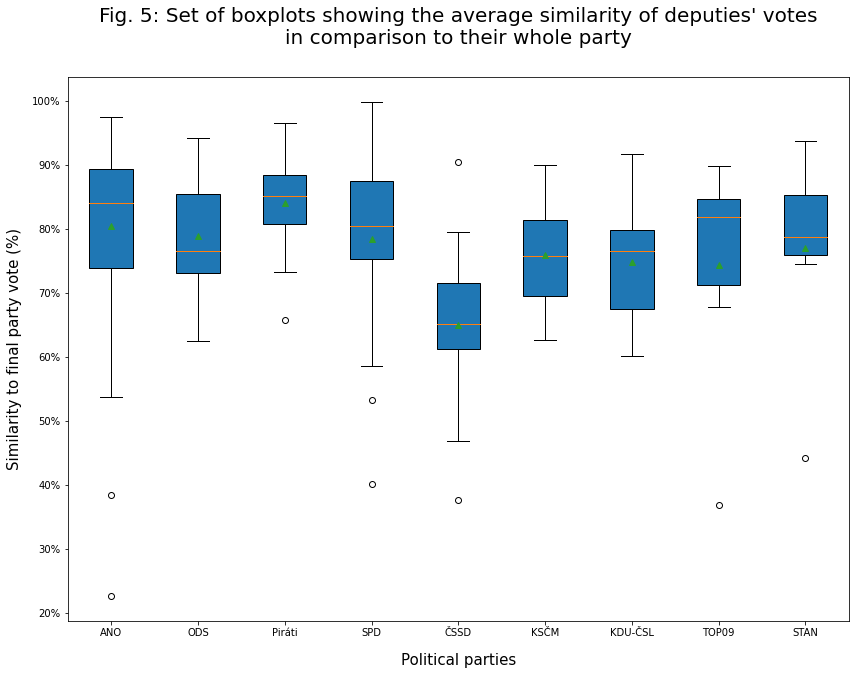

In [346]:
with open(PARTY_MEMBERS_SIMILARITY_FILE, 'r') as file:
    res = eval(file.readline())

f, ax = plt.subplots(figsize=(14, 10))
plt.boxplot(res, patch_artist=True, labels=party_list, showmeans=True)
ax.get_yaxis().set_major_formatter(FuncFormatter(fmt))
plt.ylabel('Similarity to final party vote (%)', fontsize=15, labelpad=10)
plt.xlabel('Political parties', fontsize=15, labelpad=15)
plt.title("Fig. 5: Set of boxplots showing the average similarity of deputies' votes\nin comparison to their whole party", fontsize=20, y=1.05)
plt.show()

### Interpretation
* Based on the results, we can see that members of the parties Piráti, ČSSD and STAN tend to have a narrower range of the similarities
* ČSSD has the lowest average similarity, meaning its members don't agree as often as other parties
* On the other hand, Piráti tend to stick together in their decision the most
* The average similarity across all parties seems to be around 75 - 80 %, which means that the deputies tend to mostly agree with their party's views, which makes sense
* Several parties have notable outliers, in other words members that tend to rebel from the general consensus of their party, I will therefore show these with the following script:

In [347]:
def second_smallest(numbers):
    m1, m2 = float('inf'), float('inf')
    for x in numbers:
        if x <= m1:
            m1, m2 = x, m1
        elif x < m2:
            m2 = x
    at = numbers.index(m2)
    print(f'  {names_set[at]} - ' + '{:%}'.format(m2))

def smallest(numbers):
    m = min(numbers)
    at = numbers.index(m)
    print(f'  {names_set[at]} - ' + '{:%}'.format(m))

def largest(numbers):
    m = max(numbers)
    at = numbers.index(m)
    print(f'  {names_set[at]} - ' + '{:%}'.format(m))

flags = [-2, None, -1, -2, 0, None, None, -1, -1]

for p in range(len(party_list)):
    if flags[p] == None:
        continue
    curr = df_i.loc[df_i['Party'] == party_list[p]]
    names_set = list(set(curr.Name.tolist()))
    print(f'{party_list[p]}:')
    
    if flags[p] == -1:
        smallest(res[p])
    elif flags[p] == -2:
        smallest(res[p])
        second_smallest(res[p])
    elif flags[p] == 0:
        smallest(res[p])
        largest(res[p])

ANO:
  Andrej Babiš - 22.634615%
  Martin Stropnický - 38.432122%
Piráti:
  Mikuláš Peksa - 65.878925%
SPD:
  Jana Levová - 40.223782%
  Jaroslav Foldyna - 53.229399%
ČSSD:
  Jan Hamáček - 37.656428%
  Jan Chvojka - 90.443686%
TOP09:
  Karel Schwarzenberg - 36.817962%
STAN:
  Petr Pávek - 44.289912%


* It is important to note, that some of these outliers (most notably Andrej Babiš) have a low vote similarity with their party due to having a very poor attendence at the votings

# 6. Proportions of collective votes given by each party
* The purpose of this visual is to show how each party tends to vote as a collective

### Data processing
* I simply count the number of different types of votes given by the party's members

In [348]:
party_vec = []
for p in party_list:
    p_frame = df_i.loc[df_i['Party'] == p]
    vote_vec = [
        len(p_frame.loc[p_frame['Vote'] == 'A']),
        len(p_frame.loc[p_frame['Vote'] == 'N']),
        len(p_frame.loc[p_frame['Vote'] == '0']),
        len(p_frame.loc[p_frame['Vote'] == 'Z']),
        len(p_frame.loc[p_frame['Vote'] == 'M'])
    ]
    party_vec.append(vote_vec)
    
raw_data = {'yes_bars': [party_vec[x][0] for x in range(len(party_vec))],
            'no_bars': [party_vec[x][1] for x in range(len(party_vec))],
            'unregistered_bars': [party_vec[x][2] for x in range(len(party_vec))],
            'refrained_bars': [party_vec[x][3] for x in range(len(party_vec))],
            'excused_bars': [party_vec[x][4] for x in range(len(party_vec))],
           } 
new_df = pd.DataFrame(raw_data)

### Visualization
* The chosen visual representation was a percentage bar graph, which has 5 sections given by 5 types of votes
* The y axis shows the percentage that a given section of the bar (so a specific type of vote) represents from the total number of votes of that party

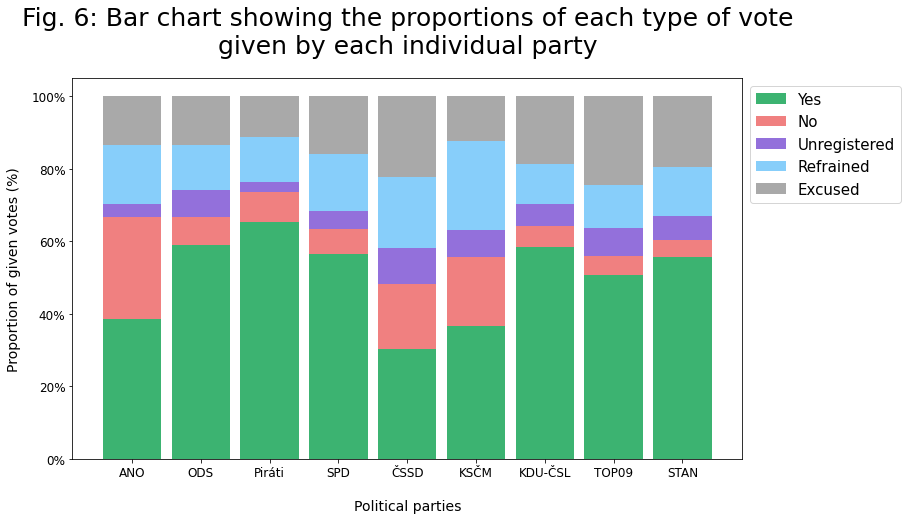

In [349]:
totals = [i + j + k + l + m for i, j, k, l, m in zip(new_df['yes_bars'], new_df['no_bars'], new_df['unregistered_bars'], new_df['refrained_bars'], new_df['excused_bars'])]

yes_bars = [i / j * 100 for i, j in zip(new_df['yes_bars'], totals)]
no_bars = [i / j * 100 for i, j in zip(new_df['no_bars'], totals)]
unregistered_bars = [i / j * 100 for i, j in zip(new_df['unregistered_bars'], totals)]
refrained_bars = [i / j * 100 for i, j in zip(new_df['refrained_bars'], totals)]
excused_bars = [i / j * 100 for i, j in zip(new_df['excused_bars'], totals)]
 
f, ax = plt.subplots(figsize=(12,7))    
    
bar_width = 0.85
r = party_list
names = party_list
plt.bar(r, yes_bars, color='mediumseagreen', width=bar_width, label='Yes')
plt.bar(r, no_bars, bottom=yes_bars, color='lightcoral', width=bar_width, label='No')
plt.bar(r, unregistered_bars, bottom=[i + j for i, j in zip(yes_bars, no_bars)], color='mediumpurple', width=bar_width, label='Unregistered')
plt.bar(r, refrained_bars, bottom=[i + j + k for i, j, k in zip(yes_bars, no_bars, unregistered_bars)], color='lightskyblue', width=bar_width, label='Refrained')
plt.bar(r, excused_bars, bottom=[i + j + k + l for i, j, k, l in zip(yes_bars, no_bars, unregistered_bars, refrained_bars)], color='darkgray', width=bar_width, label='Excused')

plt.xticks(r, names, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Fig. 6: Bar chart showing the proportions of each type of vote\ngiven by each individual party", fontsize=25, y=1.05)
plt.xlabel('Political parties', fontsize=14, labelpad=20)
plt.ylabel('Proportion of given votes (%)', fontsize=14, labelpad=10)
fmt2 = lambda x,pos: '{:.0f}%'.format(x)
ax.get_yaxis().set_major_formatter(FuncFormatter(fmt2))
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=15)
plt.show()

### Interpretation
* Based on the results, I can state that the party Piráti tends to mostly vote 'Yes', along with ODS, SPD and KDU-ČSL
* ANO, TOP09 and STAN only vote 'Yes' in roughly half of the votings and ANO actually votes 'No' almost as much as 'Yes'
* ČSSD members very often refrain from the voting or are absent